In [22]:
import numpy as np
import matplotlib.pyplot as plt
from linear_models import LinearBinaryClassifier, LinearOneVsAllClassifier
from noise_functions_multiclass import tryRegionOneVsAll
import time
%matplotlib inline

In [2]:
folders = ['randomAscent', 'greedyAscent', 'gradientDescent']

In [4]:
loss_histories = []
max_acc_histories = []

for folder in folders:
    lh = np.load('multiclass_experiments/multiclass-'+folder+"-1-17/loss_history.npy")
    loss_histories.append(lh)
    ma = np.load('multiclass_experiments/multiclass-'+folder+"-1-17/max_acc_history.npy")
    max_acc_histories.append(ma)

lh = np.load('multiclass_experiments/multiclass-gradientNonConvex-1-19/loss_history.npy')
loss_histories.append(lh)
ma = np.load('multiclass_experiments/multiclass-gradientNonConvex-1-19/max_acc_history.npy')
max_acc_histories.append(ma)

In [5]:
data_path = "multiclass_data_2"
models = []
exp_type = "multiclass"
num_classifiers = 5
alpha = .5

X_exp = np.load(data_path + "/" + "X_exp.npy")
Y_exp = np.load(data_path + "/" + "Y_exp.npy")

for i in xrange(num_classifiers):
    weights = np.load(data_path + "/" + "weights_{}.npy".format(i))
    bias = np.load(data_path + "/" + "bias_{}.npy".format(i))
    model = LinearOneVsAllClassifier(10, weights, bias)
    models.append(model)

In [24]:
ensemble_weights = sum([1.0 / num_classifiers * model.weights for model in models ])
ensemble_bias = sum([1.0 / num_classifiers * model.bias for model in models ])

In [25]:
ensemble_model = LinearOneVsAllClassifier(10, ensemble_weights, ensemble_bias)

In [26]:
ensemble_model.evaluate(X_exp, Y_exp)

1.0

In [42]:
def optNoiseMulti(model, X, Y, alpha):
    n = X.shape[0]
    noise = []
    for i in xrange(n):
        label_options = range(10)
        del label_options[Y[i]]
        v_options = []
        for j in label_options:
            v = tryRegionOneVsAll([model], [j], X[i])
            norm = np.linalg.norm(v)
            v_options.append((norm, v))
        min_v = min(v_options, key=lambda x:x[0])
        if min_v[0] < alpha:
            res = min_v[1]
        else:
            res = np.zeros(28*28)
        noise.append(res)
    return noise

In [46]:
s = time.time()
noise = optNoiseMulti(ensemble_model, X_exp, Y_exp, .5)
print time.time() - s

54.0739440918


In [49]:
for i in range(len(noise)):
    norm = np.linalg.norm(noise[i])
    if norm > 0:
        noise[i] = noise[i] / norm  * alpha

In [52]:
ensemble_res = max([model.evaluate(X_exp + noise, Y_exp) for model in models])

In [53]:
ensemble_res

0.46999999999999997

In [62]:
len(max_acc_histories)

4

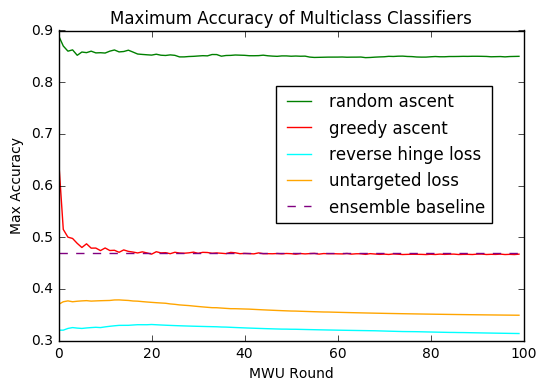

In [69]:
display_folders = ['random ascent', 'greedy ascent', 'reverse hinge loss', 'untargeted loss']
colors = ["green", "red", "cyan", "orange"]
for i, ma in enumerate(max_acc_histories):
    plt.plot(range(100), ma, color=colors[i])
plt.plot(range(100), [ensemble_res] * 100, linestyle="--", color="purple")
plt.legend(display_folders + ["ensemble baseline"], loc="right", bbox_to_anchor=(.95,.6), fontsize=12)
plt.title("Maximum Accuracy of Multiclass Classifiers")
plt.ylabel("Max Accuracy")
plt.xlabel("MWU Round")

In [15]:
max_acc_histories[-2][-1]

0.3135

In [55]:
def findAlphaEquivalent(ensemble_model, X_exp, Y_exp, alpha, target):
    noise =  optNoiseMulti(ensemble_model, X_exp, Y_exp, alpha)
    for i in range(len(noise)):
        norm = np.linalg.norm(noise[i])
        if norm > 0:
            noise[i] = noise[i] / norm  * alpha

    res = max([model.evaluate(X_exp + noise, Y_exp) for model in models])
    print alpha, res
    if res > target:
        return findAlphaEquivalent(ensemble_model, X_exp, Y_exp, alpha + .02, target)
    else:
        return alpha

In [56]:
findAlphaEquivalent(ensemble_model, X_exp, Y_exp, .5, .3135)

0.5 0.47
0.52 0.43
0.54 0.41
0.56 0.37
0.58 0.34
0.6 0.33
0.62 0.31


0.6200000000000001